In [221]:
import mamba_ssm
import torch
import matplotlib.pyplot as plt
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

In [163]:
#from mamba import Mamba2
from mamba_ssm.modules.mamba2 import Mamba2

In [164]:
layer = Mamba2(256)

In [165]:
layer.to('cuda')

Mamba2(
  (in_proj): Linear(in_features=256, out_features=1288, bias=False)
  (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
  (act): SiLU()
  (norm): RMSNorm()
  (out_proj): Linear(in_features=512, out_features=256, bias=False)
)

In [ ]:
import math
from collections import defaultdict
pow = range(6,12)
print([2**p for p in pow])
pdict = defaultdict(list)
for apow in pow:
    for n, p in Mamba2(2**apow).named_parameters():
        pdict[n].append(math.log(p.numel()))
for k,v in pdict.items():
    plt.figure()
    plt.plot(pow,v)
    plt.title(k)

In [158]:
import os
import torch
dist_dir = 'par_save'
ser_dir = 'ser_save'
files = ['input','dt','dA_cumsum','passed_states', 'states','dA_cumsum_prev']
dist_dict = {}
num_gpus=8
dir = dist_dir
for file in files:
    dist_dict[file] = torch.cat([torch.load(os.path.join(dir, f"{file}_{gpu}.pt")).detach().cpu() for gpu in range(num_gpus)], dim=1)
num_gpus=1
dir = ser_dir
ser_dict = {}
for file in files:
    ser_dict[file] = torch.cat([torch.load(os.path.join(dir, f"{file}_{gpu}.pt")).detach().cpu() for gpu in range(num_gpus)], dim=1)

/tmp/ipykernel_580986/889394315.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dist_dict[file] = torch.cat([torch.load(os.path.join(dir, f"{file}_{gpu}.pt")).detach().

In [159]:
for k,v in ser_dict.items():
    print(k,v.shape)
for k,v in dist_dict.items():
    print(k,v.shape)

input torch.Size([8, 8192, 256])
dt torch.Size([8, 8192, 8])
dA_cumsum torch.Size([8, 32, 8, 256])
passed_states torch.Size([8, 32, 8, 64, 128])
states torch.Size([8, 32, 8, 64, 128])
dA_cumsum_prev torch.Size([2, 32, 8, 256])
input torch.Size([8, 8192, 256])
dt torch.Size([8, 8192, 8])
dA_cumsum torch.Size([8, 32, 8, 256])
passed_states torch.Size([8, 32, 8, 64, 128])
states torch.Size([8, 32, 8, 64, 128])
dA_cumsum_prev torch.Size([2, 32, 8, 256])


In [133]:
print(8192/256, 'num chunks')
print(256*2/64, 'num_heads')

32.0 num chunks
8.0 num_heads


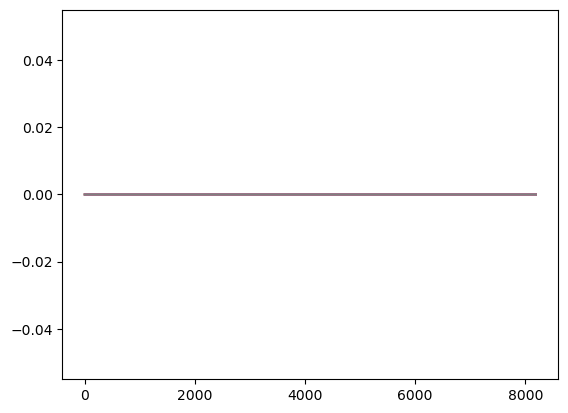

In [160]:
for i in range(8):
    #plt.figure()
    plt.plot(ser_dict['input'][i,:,0]-dist_dict['input'][i,:,0])

/tmp/ipykernel_580986/4054769625.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sequence = torch.cat(torch.load('par_save/sequence_0.pt'), dim=1).cpu()
/tmp/ipykernel_5

torch.Size([8, 8192, 256]) torch.Size([8, 8192, 256])


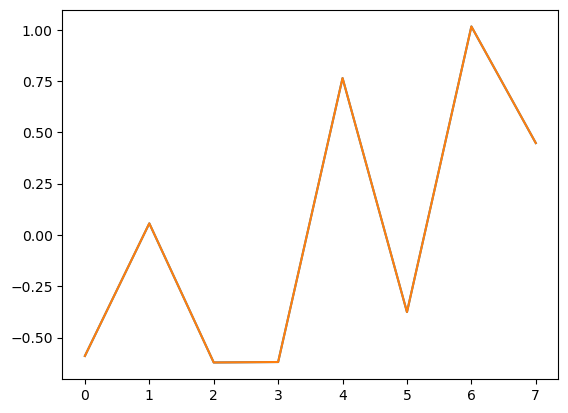

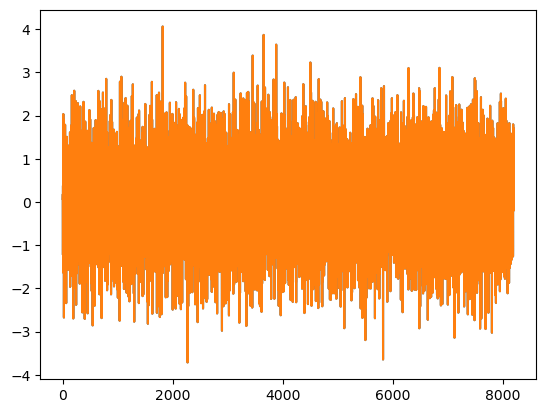

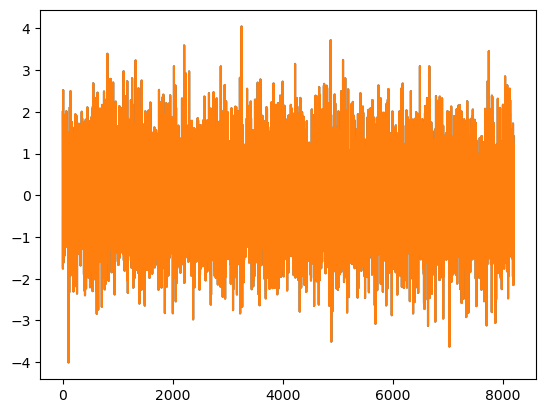

In [161]:
sequence = torch.cat(torch.load('par_save/sequence_0.pt'), dim=1).cpu()
seq_gpu = torch.cat([torch.load(os.path.join('par_save', f"input_{gpu}.pt")).detach().cpu() for gpu in range(8)], dim=1)
print(sequence.shape, seq_gpu.shape)
plt.plot(seq_gpu[:,24,0])
plt.plot(sequence[:,24,0])
plt.figure()
plt.plot(seq_gpu[1,:,0])
plt.plot(sequence[1,:,0])
plt.figure()
plt.plot(seq_gpu[0,:,0])
plt.plot(sequence[0,:,0])
#plt.plot(seq_gpu[4,:,:].flatten()-sequence[4,:,:].flatten())
#plt.plot(dist_dict['input'][0,:,0].flatten()-sequence[2,:,:].flatten())
#plt.figure()
#plt.plot(ser_dict['input'][2,:,:].flatten()-sequence[2,:,:].flatten())


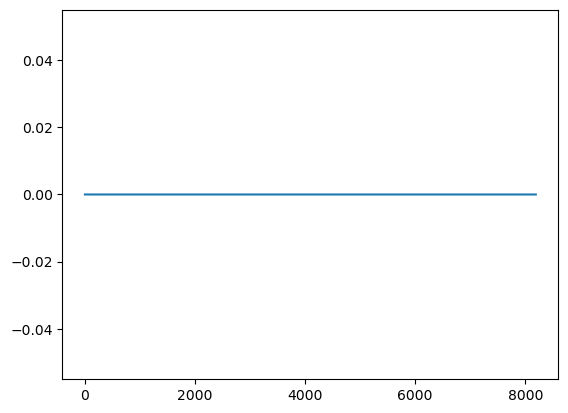

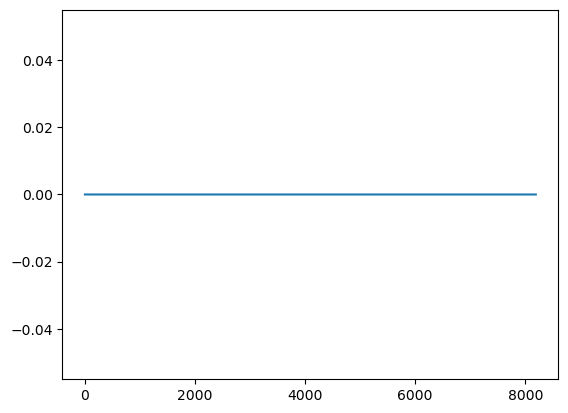

In [162]:
for i in range(2):
    plt.figure()
    #plt.plot(ser_dict['dA_cumsum'].sum(dim=(2,3))[i,:], 'o')
    #plt.plot(dist_dict['dA_cumsum'].sum(dim=(2,3))[i,:],'x')
    plt.plot(ser_dict['dt'][i,:,0]-dist_dict['dt'][i,:,0])

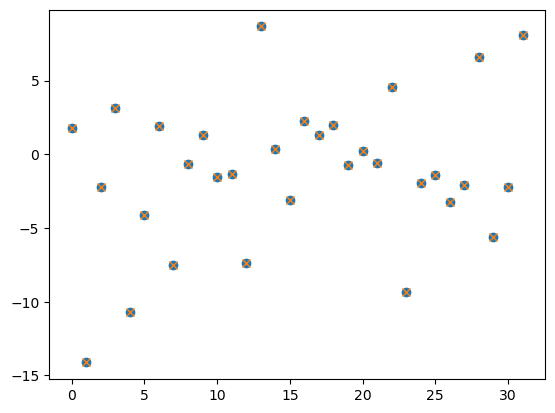

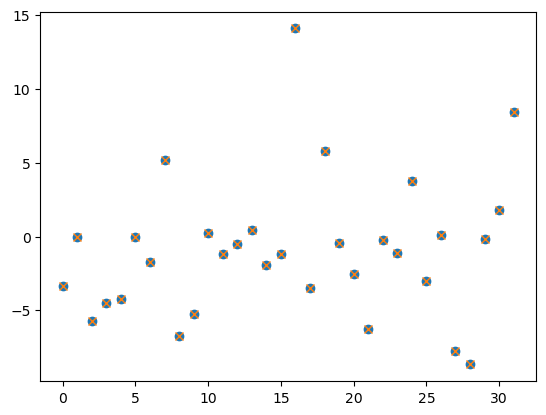

In [163]:
for i in range(2):
    plt.figure()
    plt.plot(ser_dict['states'].sum(dim=(2,3,4))[i,:], 'o')
    plt.plot(dist_dict['states'].sum(dim=(2,3,4))[i,:],'x')

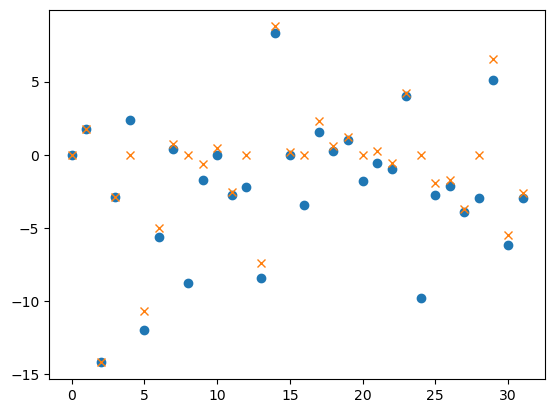

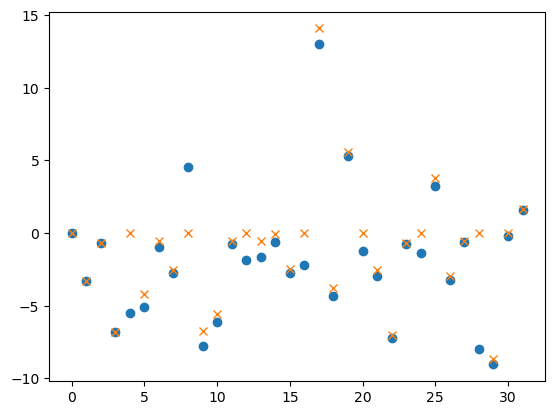

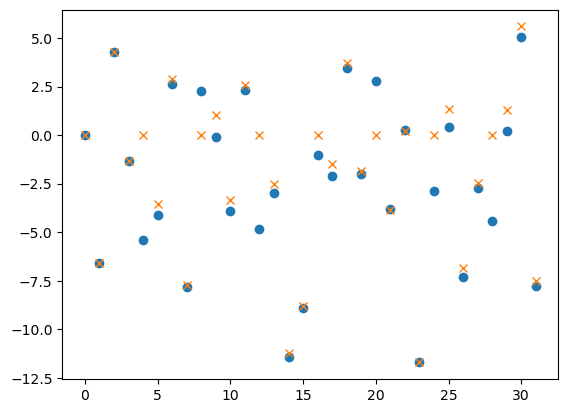

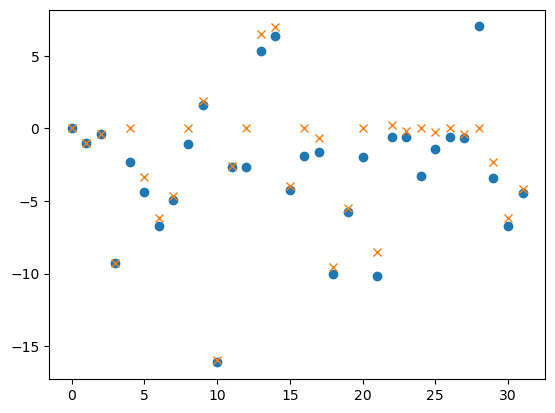

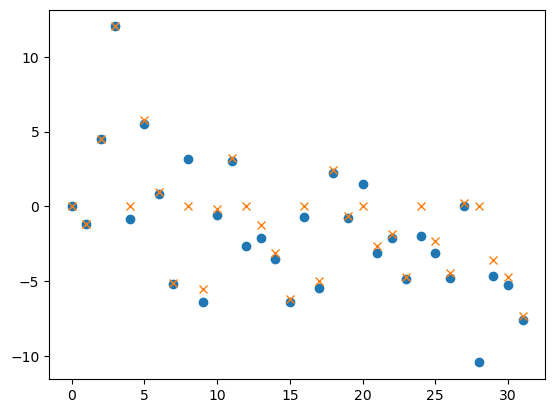

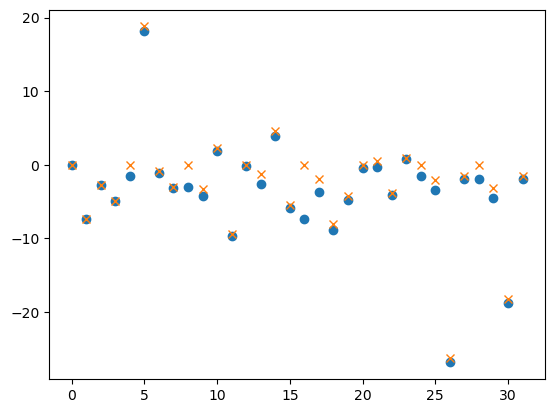

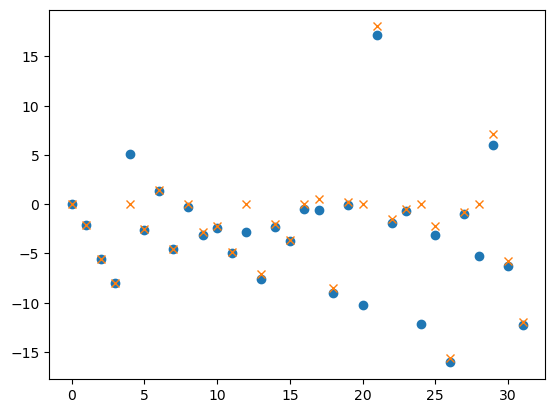

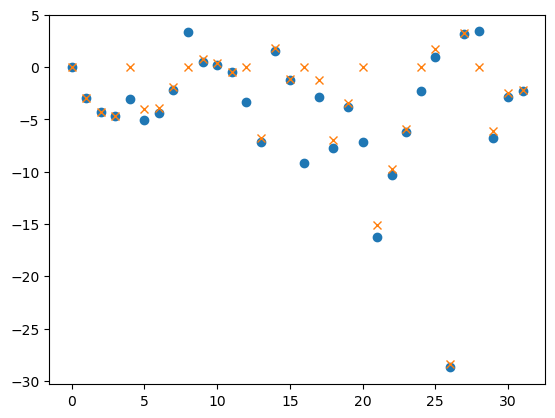

In [165]:
for i in range(8):
    plt.figure()
    plt.plot(ser_dict['passed_states'].sum(dim=(2,3,4))[i,:],'o')
    plt.plot(dist_dict['passed_states'].sum(dim=(2,3,4))[i,:],'x')

In [57]:
def reduce(tensor_list, states, dA_cumsum, chunks_per_gpu):
    """
    states are the passed states for a gpu
    tesnor list is the list of final states per gpu (passed but not with states form other gpus)
    
    """
    rank = len(tensor_list)
    states_per_gpu = states.shape[1]
    print('rank',rank)
    #if rank == 1:
    #    return states
    expdA = torch.exp(dA_cumsum[:, :, :, -1]) #dA_cumsum (b,h,c,dim_c) #State passing get's last element for some reason
    print(f"{expdA.shape = }")
    print('x,r,g,start,end')
    for x in range(states_per_gpu): #Intra GPU Chunk #
        for gpu,final_state in enumerate(tensor_list,start=1):
            #if gpu == rank:
            #    break
            start, end = gpu*chunks_per_gpu-1, rank*chunks_per_gpu+x
            #print(x, rank, gpu, start,end)
            scale = torch.prod(expdA[:,:,start:end], dim = 2)
            #print(scale.shape, states[:,i,:,:].shape)
            scale = scale[:,:,None,None]
            #print(scale)
            states[:,x,:,:] += final_state*scale
    return states

def reduce_ref(states, dA_cumsum):
    nstates = states.shape[1]
    states_out = []
    #print(states.shape)
    state = torch.zeros_like(states[:,0,:,:])
    expdA = torch.exp(dA_cumsum[:, :, :, -1])
    for i in range(nstates):
        scale = torch.exp(expdA[:,i,:])
        state = state + scale[:,:,None,None]*states[:,i,:,:]
        #print(state.shape)
        states_out.append(state.unsqueeze(1))
    return torch.concat(states_out, dim = 1)

In [58]:
res1 = reduce_ref(torch.concat(dist_dict['states'], dim = 1).clone(),
                 torch.concat(dist_dict['dA_cumsum'], dim=1))
res2 = reduce_ref(ser_dict['states'].clone(),
                 ser_dict['dA_cumsum'])
#print(res.shape)

In [45]:
from einops import rearrange
res = []
n_chunks_per_gpu = 32//8
res = torch.concat([reduce(dist_dict['final_states'][:rank],
              dist_dict['states'][rank].clone(),
              rearrange(torch.concat(dist_dict['dA_cumsum'],dim=1), 'i j k l -> i k j l'),
              n_chunks_per_gpu,) if rank else dist_dict['states'][rank].clone() for rank in range(0,8)], dim=1)

rank 1
expdA.shape = torch.Size([2, 8, 32])
x,r,g,start,end
rank 2
expdA.shape = torch.Size([2, 8, 32])
x,r,g,start,end
rank 3
expdA.shape = torch.Size([2, 8, 32])
x,r,g,start,end
rank 4
expdA.shape = torch.Size([2, 8, 32])
x,r,g,start,end
rank 5
expdA.shape = torch.Size([2, 8, 32])
x,r,g,start,end
rank 6
expdA.shape = torch.Size([2, 8, 32])
x,r,g,start,end
rank 7
expdA.shape = torch.Size([2, 8, 32])
x,r,g,start,end


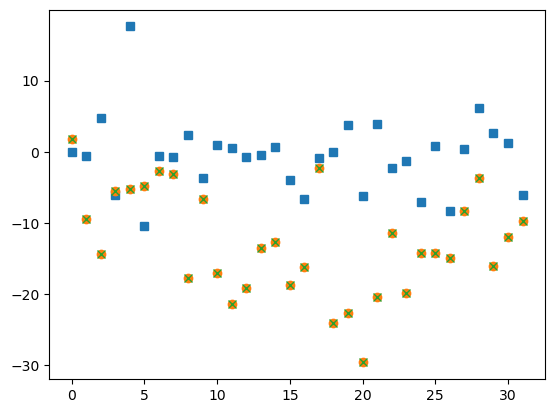

In [59]:
import matplotlib.pyplot as plt
plt.plot(ser_dict['passed_states'].sum(dim=(2,3,4))[0,:],'s')
plt.plot(res1.sum(dim=(2,3,4))[0,:],'o')
plt.plot(res2.sum(dim=(2,3,4))[0,:],'x')
#plt.plot(torch.concat(dist_dict['states'], dim=1).sum(dim=(2,3,4))[0,:],'x')

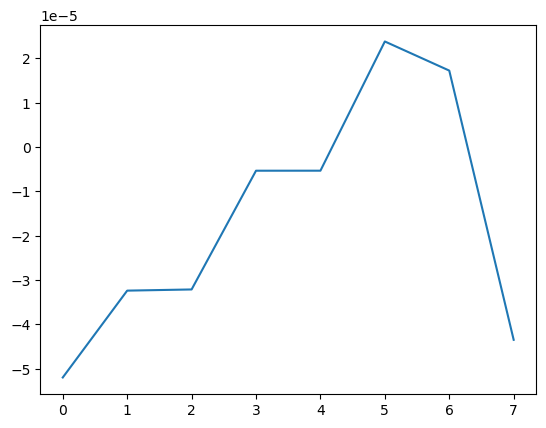

In [252]:
plt.plot([x.mean() for x in dist_dict['states']])

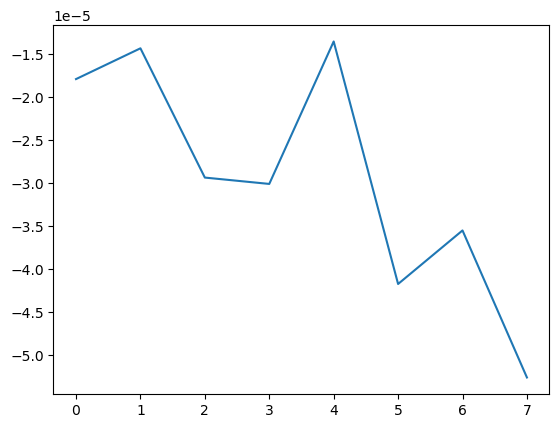

In [167]:
plt.plot([x.mean() for x in dist_dict['states']])

In [236]:
#res.shap

In [172]:
from einops import rearrange
from mamba_ssm.ops.triton.ssd_state_passing import _state_passing_fwd
def pass_states(dA_cumsum, states, initial_states=None, seq_idx=None, chunk_size=128):
    print(states.shape)
    #print(dA_cumsum.shape)
    initial_states = initial_states.to('cuda') if initial_states is not None else initial_states
    dstate = states.shape[-1]
    states = states.to('cuda')
    dA_cumsum = rearrange(dA_cumsum,'i j k l -> i k j l').to('cuda')
    states, final_states = _state_passing_fwd(rearrange(states, "... p n -> ... (p n)"), dA_cumsum[:, :, :, -1],
                                                  initial_states=rearrange(initial_states, "... p n -> ... (p n)") if initial_states is not None else None,
                                                  seq_idx=seq_idx, chunk_size=chunk_size, out_dtype=torch.float32)
    states, final_states = [rearrange(t, "... (p n) -> ... p n", n=dstate) for t in [states, final_states]]
    return states, final_states
        

In [176]:
import os
import torch
dist_dir = 'par_save'
ser_dir = 'ser_save'
files = ['input','dt','dA_cumsum','passed_states', 'states','final_states']
dist_dict = {}
num_gpus=8
dir = dist_dir
for file in files:
    dist_dict[file] = [torch.load(os.path.join(dir, f"{file}_{gpu}.pt")).detach().cpu() for gpu in range(num_gpus)]
num_gpus=1
dir = ser_dir
ser_dict = {}
for file in files:
    ser_dict[file] = [torch.load(os.path.join(dir, f"{file}_{gpu}.pt")).detach().cpu() for gpu in range(num_gpus)]

/tmp/ipykernel_580986/2595076276.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dist_dict[file] = [torch.load(os.path.join(dir, f"{file}_{gpu}.pt")).detach().cpu() for

In [206]:
ser_dict['repassed_states'] = [pass_states(ser_dict['dA_cumsum'][0],ser_dict['states'][0])[0].cpu()]
dist_dict['repassed_states'] = [pass_states(dist_dict['dA_cumsum'][0],dist_dict['states'][0])[0].cpu()]
for dA_cumsum, state, final_state in zip(dist_dict['dA_cumsum'][1:],dist_dict['states'][1:],dist_dict['final_states']):
    dist_dict['repassed_states'].append(pass_states(dA_cumsum, state, final_state)[0].cpu())
state, final_state = pass_states(dist_dict['dA_cumsum'][0],dist_dict['states'][0])
dist_dict['repassed_states2'] = [state.cpu()]
for dA_cumsum, state in zip(dist_dict['dA_cumsum'][1:],dist_dict['states'][1:]):
    state, final_state = pass_states(dA_cumsum, state)#, final_state)
    dist_dict['repassed_states2'].append(state.cpu())

torch.Size([8, 32, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])


Text(0, 0.5, '$h$')

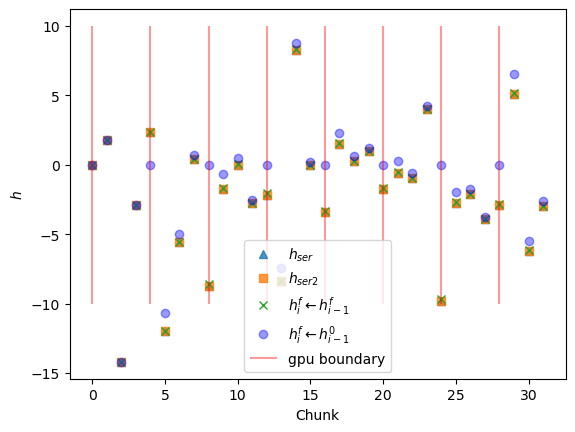

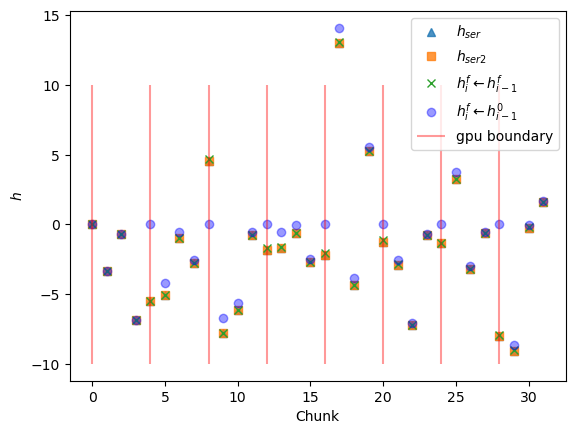

In [216]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ser_dict['passed_states'][0].sum(dim=(2,3,4))[0,:],'^',alpha=0.8)
plt.plot(ser_dict['repassed_states'][0].sum(dim=(2,3,4))[0,:],'s',alpha=0.8)
plt.plot(torch.concat(dist_dict['repassed_states'], dim=1).sum(dim=(2,3,4))[0,:],'x')
plt.plot(torch.concat(dist_dict['repassed_states2'], dim=1).sum(dim=(2,3,4))[0,:],'bo', alpha=0.4)
vlines = range(0,32,4)
plt.vlines(vlines,-10,10,'r',alpha=0.4)
plt.legend(['$h_{ser}$','$h_{ser2}$','$h^f_{i}\leftarrow h^f_{i-1}$','$h^f_{i}\leftarrow h^0_{i-1}$','gpu boundary'])
plt.xlabel('Chunk')
plt.ylabel('$h$')
plt.figure()
plt.plot(ser_dict['passed_states'][0].sum(dim=(2,3,4))[1,:],'^',alpha=0.8)
plt.plot(ser_dict['repassed_states'][0].sum(dim=(2,3,4))[1,:],'s',alpha=0.8)
plt.plot(torch.concat(dist_dict['repassed_states'], dim=1).sum(dim=(2,3,4))[1,:],'x')
plt.plot(torch.concat(dist_dict['repassed_states2'], dim=1).sum(dim=(2,3,4))[1,:],'bo',alpha=0.4)
vlines = range(0,32,4)
plt.vlines(vlines,-10,10,'r',alpha=0.4)
plt.legend(['$h_{ser}$','$h_{ser2}$','$h^f_{i}\leftarrow h^f_{i-1}$','$h^f_{i}\leftarrow h^0_{i-1}$','gpu boundary'])
plt.xlabel('Chunk')
plt.ylabel('$h$')

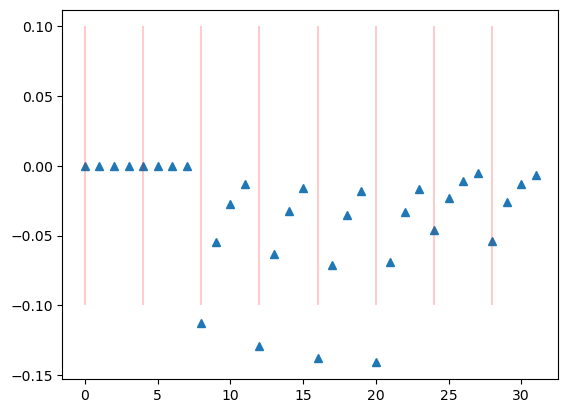

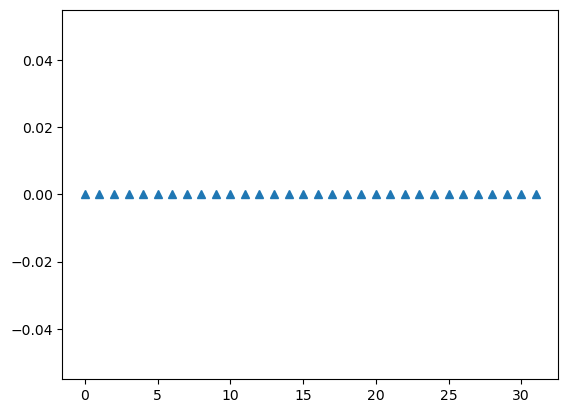

In [224]:
plt.figure()
plt.plot(ser_dict['repassed_states'][0].sum(dim=(2,3,4))[1,:]-torch.concat(dist_dict['repassed_states'], dim=1).sum(dim=(2,3,4))[1,:],'^')
vlines = range(0,32,4)
plt.vlines(vlines,-0.1,0.1,'r',alpha=0.2)

plt.figure()
plt.plot(ser_dict['passed_states'][0].sum(dim=(2,3,4))[1,:]-ser_dict['repassed_states'][0].sum(dim=(2,3,4))[1,:],'^')
#vlines = range(0,32,4)
#plt.vlines(vlines,-0.00001,0.00001,'r',alpha=0.2)